Analysis of a running AERA experiment

In [1]:
import numpy as np, datetime, cf_units, nc_time_axis, cftime, sys, os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
import iris, iris_tools as itools
sys.path.append('/g/data1a/p66/mrd599/venv/aera/lib/python3.9/site-packages')
import aera
from collections import namedtuple
from notebook_metadata import create_savefig

%matplotlib inline
plt.style.use('mrd_presentation')
savefig = create_savefig(dir='/g/data/p66/mrd599/temp', nb='AERA_analysis_all.ipynb')

# Need this to match cftime dates
mdates.set_epoch("2000-01-01")

In [36]:
tas = {}
co2 = {}
label = {}
runs = []
# for case in [3,4]:
for case in [3]:
    # for type in ('ABS', 'REL'):
    for type in ('ABS', 'REL'):
        for target in ('1p5', '2p0'):
            RUNID = f'AERA2-{type}{target}-{case:02d}'
            expdir = f"/scratch/p66/mrd599/ACCESS-ESM1p5/exp/{RUNID}"
            if os.path.exists(expdir):
                runs.append(RUNID)
                tas[RUNID] = xr.load_dataset(f'{expdir}/aera_data/aera_input_{RUNID}.nc', use_cftime=True).tas
                co2[RUNID] = xr.load_dataset(f'{expdir}/aera_data/aera_input_{RUNID}.nc', use_cftime=True).co2
                if target == '2p0':
                    label[RUNID] = f'{type} 2.0'
                else:
                    label[RUNID] = f'{type} 1.5'

zorder = {'AERA2-ABS1p5-03':4, 'AERA2-ABS2p0-03':3, 'AERA2-REL1p5-03':2, 'AERA2-REL2p0-03':1}

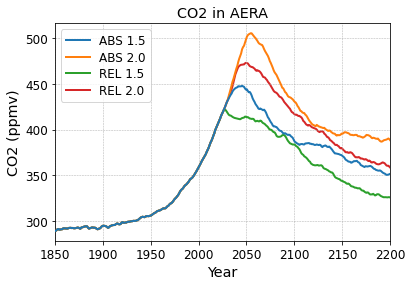

In [37]:
lastyear = 2200  # For plots
C_CO2        = 1.5188
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
# t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
# t1 = taxis.date2num(datetime.datetime(lastyear,1,1,0,0,0))
t0 = taxis.date2num(cftime.DatetimeProlepticGregorian(1850,1,1))
t1 = taxis.date2num(cftime.DatetimeProlepticGregorian(lastyear,1,1))
fig, axes = plt.subplots()
for RUNID in runs:
    (co2[RUNID]/C_CO2*1e6).plot(label=label[RUNID], zorder=zorder[RUNID])

axes.set_ylabel('CO2 (ppmv)')
axes.set_title('CO2 in AERA')
axes.grid(True)
axes.set_xlim(t0,t1)
axes.set_xlabel('Year')
date_form = mdates.DateFormatter("%Y")
# # Undo the rotation that xarray normally uses
# fig.autofmt_xdate(rotation=0, ha='center')
axes.xaxis.set_major_formatter(date_form)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,lastyear+1,50)]
# ticks = [taxis.date2num(cftime.DatetimeProlepticGregorian(y,1,1)) for y in np.arange(1850,lastyear+1,50)]
axes.set_xticks(ticks)
axes.legend()
savefig('aera_co2.png')

In [14]:
aera = {}
adata = namedtuple("aera_data", 'dm year total_emission_budget ff_emission_budget')
for RUNID in runs:
    dm = {}
    year = []
    total_emission_budget = []
    ff_emission_budget = []
    expdir = f"/scratch/p66/mrd599/ACCESS-ESM1p5/exp/{RUNID}"
    for y in range(2025,2501,5):
        try:
            dm[y] = xr.load_dataset(f'{expdir}/aera_data/meta_data_{y}.nc')
        except FileNotFoundError:
            break
        year.append(y)
        # These are strings for some reason
        total_emission_budget.append(float(dm[y].total_emission_budget.values[0]))
        ff_emission_budget.append(float(dm[y].ff_emission_budget.values[0]))
    aera[RUNID] = adata(dm, year, total_emission_budget, ff_emission_budget)


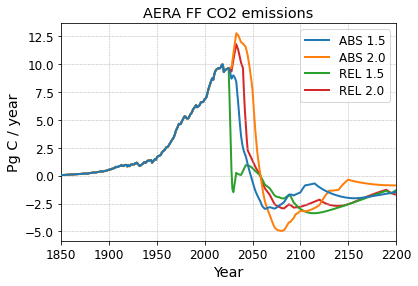

In [38]:
fig, axes = plt.subplots()
# label = {'AERA2-ABS1p5-03':'1.5$\degree$ target', 'AERA2-ABS2p0-03':'2.0$\degree$ target'}
for run in runs:
    # aera[run].dm[2025].ff_emission[0].plot(label=run)
    lastyear = aera[run].year[-1]
    # aera[run].dm[lastyear].ff_emission[0].plot(label=run)
    aera[run].dm[lastyear].ff_emission[0].plot(label=label[run], zorder=zorder[run])
axes.legend(loc='upper right')
axes.set_title('AERA FF CO2 emissions')
axes.grid(True)
axes.set_xlim(1850,2200)
axes.set_xlabel('Year')
axes.set_ylabel('Pg C / year')
savefig('aera_emissions.png')

Text(0.5, 0, 'Year')

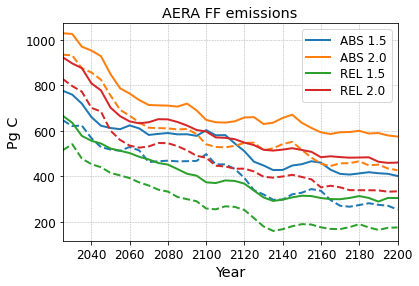

In [20]:
fig, axes = plt.subplots()
for i, run in enumerate(runs):
    # aera[run].dm[2025].ff_emission[0].plot(label=run)
    color = f'C{i}'
    plt.plot(aera[run].year, aera[run].total_emission_budget, color=color, label=label[run])
    plt.plot(aera[run].year, aera[run].ff_emission_budget, linestyle='--', color=color)
axes.legend(loc='upper right')
axes.set_title('AERA FF emissions')
axes.grid(True)
axes.set_xlim(2025,2200)
axes.set_ylabel('Pg C')
axes.set_xlabel('Year')
# savefig('aera_emissions.png')

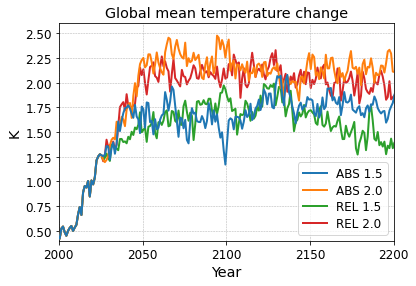

In [48]:
fig, axes = plt.subplots()
for run in runs:
    # (tas[run] - tas[run][:50].mean()).plot(label=run)
    (tas[run] - tas[run][:50].mean()).plot(label=label[run], zorder=zorder[run])
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(2200,1,1,0,0,0))
t0 = taxis.date2num(datetime.datetime(2000,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(2200,1,1,0,0,0))

axes.set_ylabel('K')
axes.set_title('Global mean temperature change')
axes.grid(True)
axes.legend()
axes.set_xlim(t0,t1)
axes.set_ylim(0.4,2.6)
axes.set_xlabel('Year')
date_form = mdates.DateFormatter("%Y")
axes.xaxis.set_major_formatter(date_form)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,2201,50)]
# axes.set_xticks(ticks)
axes.grid(True)
savefig('aera_temp.png')

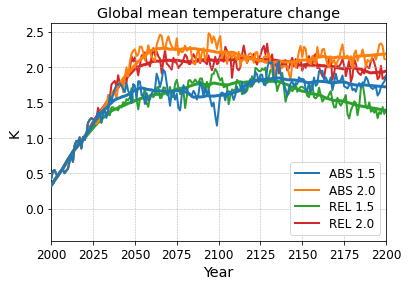

In [42]:
fig, axes = plt.subplots()
for i, run in enumerate(runs):
    # (tas[run]).plot(label=run)
    color = f'C{i}'
    base = tas[run][:50].mean()
    plt.plot(np.arange(1850,1850+len(tas[run])), tas[run] - base, color=color, 
             label=label[run], zorder=zorder[run])
    lastyear = aera[run].year[-1]
    (aera[run].dm[lastyear].temp_anth[0]-base).plot(color=color, zorder=zorder[run], lw=3)
    # (tas[run] - tas[run][:50].mean()).plot(label=run)

axes.set_ylabel('K')
axes.set_title('Global mean temperature change')
axes.grid(True)
axes.legend()
axes.set_xlim(2000,2200)
axes.set_xlabel('Year')
axes.grid(True)
savefig('aera_temp.png')